<a href="https://colab.research.google.com/github/VasundharaAgarwal/GANFingerprinting/blob/main/GAN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
import os

In [ ]:
nnodes = 128*7*7
nz = 100
#learning rate for optimizers
lr = 0.0002
batch_size = 256
real_label = 1
fake_label = 0
num_epochs = 10
ngpu = 1
beta1 = 0.5

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True, transform=torchvision.transforms.ToTensor()), batch_size=batch_size)
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True, transform=torchvision.transforms.ToTensor()), batch_size = batch_size)
device = torch.device("cuda:0")

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
  def __init__(self, ngpu):
      super(Generator, self).__init__()
      self.ngpu = ngpu
      self.linear = nn.Linear(nz, nnodes, bias=True)
      self.leakyReLU1 = nn.LeakyReLU(0.2)
      self.convTr1 = nn.ConvTranspose2d(128, 128, 4, 2, 1, bias=False)
      self.leakyReLU2 = nn.LeakyReLU(0.2)
      self.convTr2 = nn.ConvTranspose2d(128, 128, 4, 2, 1, bias=False)
      self.leakyReLU3 = nn.LeakyReLU(0.2)
      self.conv1 = nn.Conv2d(128, 1, 7, 1, 3, bias=False)

  def forward(self, x):
      x = self.linear(x.view(-1,1,1,100))
      x = self.leakyReLU1(x)
      x = x.view(-1,128, 7, 7)
      x = self.leakyReLU2(self.convTr1(x))
      x = self.leakyReLU3(self.convTr2(x))
      x = torch.sigmoid(self.conv1(x))
      return x


In [ ]:

netG = Generator(ngpu).to(device)
netG.apply(weights_init)

Generator(
  (linear): Linear(in_features=100, out_features=6272, bias=True)
  (leakyReLU1): LeakyReLU(negative_slope=0.2)
  (convTr1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (leakyReLU2): LeakyReLU(negative_slope=0.2)
  (convTr2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (leakyReLU3): LeakyReLU(negative_slope=0.2)
  (conv1): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
      super(Discriminator, self).__init__()
      self.ngpu = ngpu
      self.conv1 = nn.Conv2d(1, 64, 3, 2, 1, bias=False)
      self.leakyReLU1 = nn.LeakyReLU(0.2)
      self.dropout1 = nn.Dropout(0.4)
      self.conv2 = nn.Conv2d(64, 64, 3, 2, 1, bias=False)
      self.leakyReLU2 = nn.LeakyReLU(0.2)
      self.dropout2 = nn.Dropout(0.4)
      self.flatten = nn.Flatten()
      self.linear = nn.Linear(3136, 1, bias=True)
      self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      x = self.conv1(x)
      x = self.dropout1(self.leakyReLU1(x))
      x = self.conv2(x)
      x = self.dropout2(self.leakyReLU2(x))
      x = self.sigmoid(self.linear(self.flatten(x)))
      return x


In [ ]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (leakyReLU1): LeakyReLU(negative_slope=0.2)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (leakyReLU2): LeakyReLU(negative_slope=0.2)
  (dropout2): Dropout(p=0.4, inplace=False)
  (flatten): Flatten()
  (linear): Linear(in_features=3136, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    print(epoch)
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        print("here")
        iters += 1

Starting Training Loop...
0
[0/10][0/235]	Loss_D: 1.3821	Loss_G: 0.6685	D(x): 0.5264	D(G(z)): 0.5222 / 0.5129
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
[0/10][50/235]	Loss_D: 1.3779	Loss_G: 0.7156	D(x): 0.4962	D(G(z)): 0.4910 / 0.4892
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
[0/10][100/235]	Loss_D: 1.3740	Loss_G: 0.7385	D(x): 0.4902	D(G(z)): 0.4828 / 0.4783
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
her

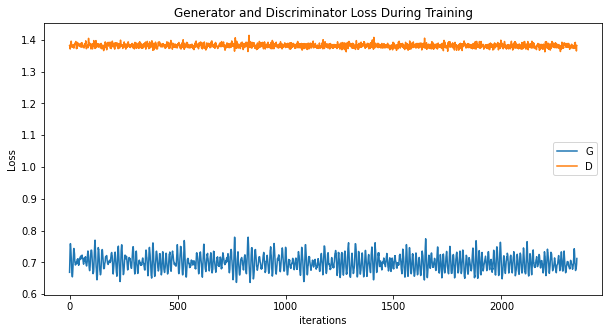

2350

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
len(G_losses)

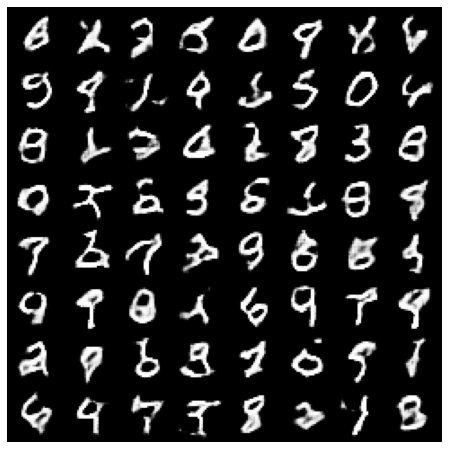

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
torch.save(netG.state_dict(), F'/g.pt')
torch.save(netD.state_dict(), F'/d.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
torch.save(netG.state_dict(), 'gdrive/My Drive/g.pt')
torch.save(netD.state_dict(), 'gdrive/My Drive/d.pt')